# Predict Future Sales Eda

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [2]:
item_categories = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
sales_train = pd.read_csv('../data/sales_train.csv')
test = pd.read_csv('../data/test.csv')

### General

In [3]:
display(items.head())
display(item_categories.head())
display(shops.head())
display(sales_train.head())

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

* Let's check missing values

In [4]:
data = [items, item_categories, shops, sales_train]
for table in data:
    print(table.isnull().sum())

item_name           0
item_id             0
item_category_id    0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


* No missing values

* Let's check duplicates and remove them if there are some

In [5]:
for table in data:
    print(table.duplicated().sum())

0
0
0
6


In [6]:
sales_train = sales_train.drop_duplicates().reset_index(drop=True)

In [7]:
sales_train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06
mean     1.456991e+01  3.300171e+01  1.019723e+04  8.908535e+02  1.242641e+00
std      9.422992e+00  1.622698e+01  6.324293e+03  1.729801e+03  2.618837e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03

* There are some negative values in fields 'item_price' and 'item_cnt_day', will deal with them in outliers section

### Categories

In [8]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [9]:
print(len(item_categories))
print(item_categories.item_category_name.nunique())

84
84


In [10]:
list(item_categories.item_category_name)

['PC - Гарнитуры/Наушники',
 'Аксессуары - PS2',
 'Аксессуары - PS3',
 'Аксессуары - PS4',
 'Аксессуары - PSP',
 'Аксессуары - PSVita',
 'Аксессуары - XBOX 360',
 'Аксессуары - XBOX ONE',
 'Билеты (Цифра)',
 'Доставка товара',
 'Игровые консоли - PS2',
 'Игровые консоли - PS3',
 'Игровые консоли - PS4',
 'Игровые консоли - PSP',
 'Игровые консоли - PSVita',
 'Игровые консоли - XBOX 360',
 'Игровые консоли - XBOX ONE',
 'Игровые консоли - Прочие',
 'Игры - PS2',
 'Игры - PS3',
 'Игры - PS4',
 'Игры - PSP',
 'Игры - PSVita',
 'Игры - XBOX 360',
 'Игры - XBOX ONE',
 'Игры - Аксессуары для игр',
 'Игры Android - Цифра',
 'Игры MAC - Цифра',
 'Игры PC - Дополнительные издания',
 'Игры PC - Коллекционные издания',
 'Игры PC - Стандартные издания',
 'Игры PC - Цифра',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Карты оплаты - Live!',
 'Карты оплаты - Live! (Цифра)',
 'Карты оплаты - PSN',
 'Карты оплаты - Windows (Цифра)',
 'Кино - Blu-Ray',
 'Кино - Blu-Ray 3D',
 'Кино - Blu-Ray 4K',
 'Кино - DV

* Let's separate the main category from the sub one and make two different features

In [11]:
item_categories['item_sub_category'] = item_categories.item_category_name.str.split(' - ').str.get(1)
item_categories.item_category_name = item_categories.item_category_name.str.split(' - ').map(lambda x: x[0])
item_categories.fillna('-', inplace=True)
item_categories.sample(5)

item_category_name  item_category_id  item_sub_category
79          Служебные                79                  -
67            Подарки                67           Развитие
59             Музыка                59  Музыкальное видео
64            Подарки                64    Настольные игры
2          Аксессуары                 2                PS3

* Let's check the most selling categories

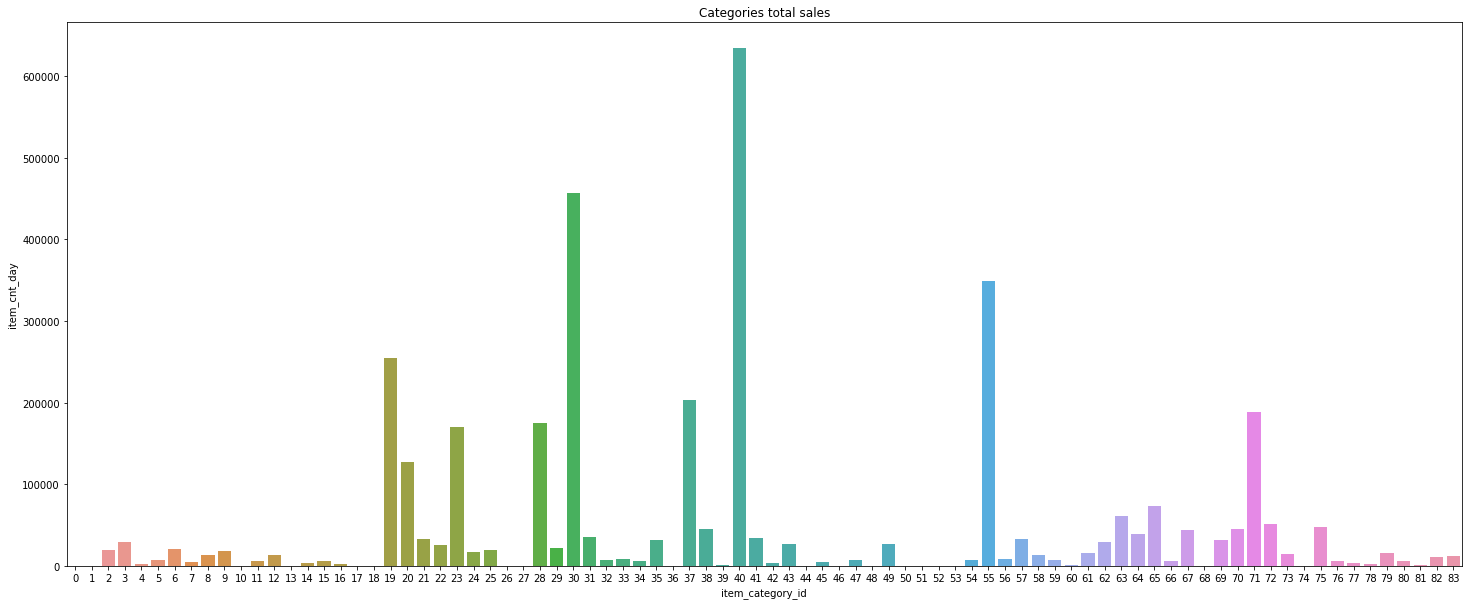

In [12]:
fig = plt.figure(figsize=(25, 10))
sns.barplot(x='item_category_id',
            y='item_cnt_day',
            data=sales_train.merge(items, on='item_id', how='left').groupby('item_category_id').aggregate(
            {'item_cnt_day' : 'sum'}).reset_index())
plt.title('Categories total sales')
plt.show()

* Only 9 categoties represent most of the total sales amount

### Items

In [13]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [14]:
print(len(items))
print(items.item_name.nunique())

22170
22170


Text(0.5, 1.0, 'Number of items on each category')

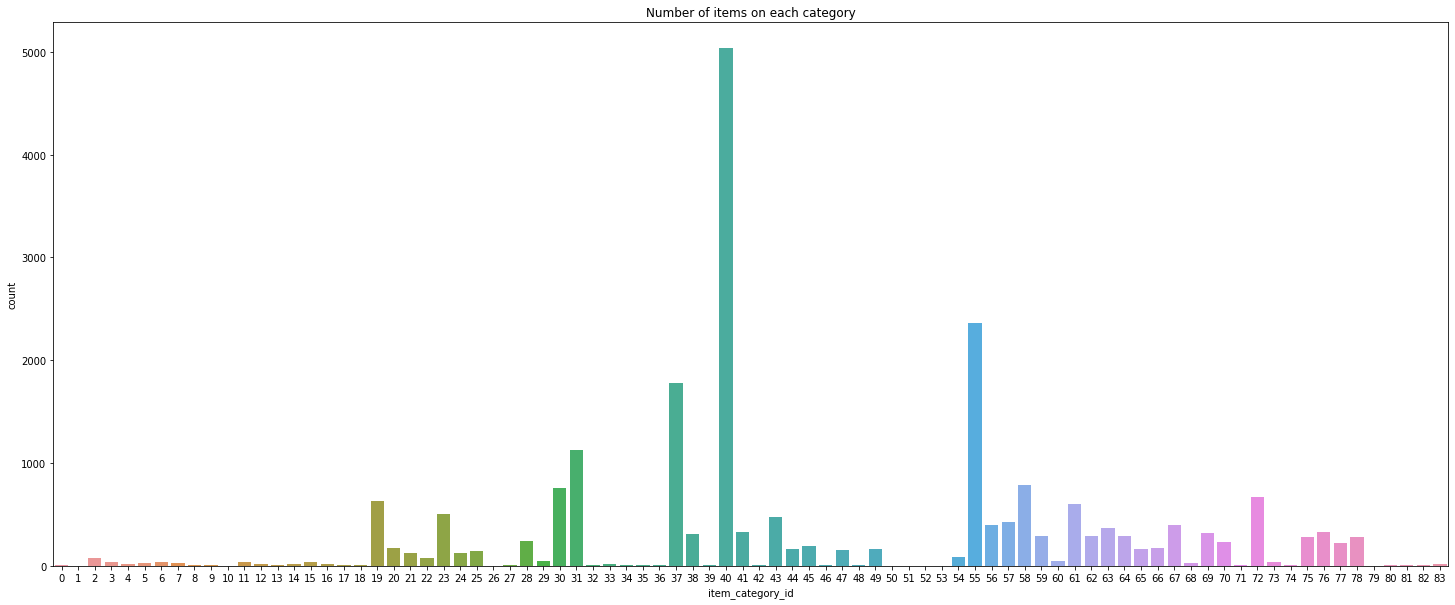

In [15]:
fig = plt.figure(figsize=(25, 10))
sns.countplot(x='item_category_id', data=items)
plt.title('Number of items on each category')

### Shops

In [16]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [17]:
print(len(shops))
print(shops.shop_name.nunique())

60
60


* Let's extract and add city feature to the shops table

In [18]:
shops['city'] = shops['shop_name'].str.extract(r'(\w+\.*\w*)')
shops.loc[shops.city == 'Выездная', 'city'] = 'Выездная торговля'
shops.loc[shops.city == 'РостовНаДону', 'city'] = 'Ростов-На-Дону'
shops.loc[shops.city == 'Сергиев', 'city'] = 'Сергиев Посад'
shops.loc[shops.city == 'Цифровой', 'city'] = 'Интернет'
shops.head()

shop_name  shop_id      city
0   !Якутск Орджоникидзе, 56 фран        0    Якутск
1   !Якутск ТЦ "Центральный" фран        1    Якутск
2                Адыгея ТЦ "Мега"        2    Адыгея
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха
4        Волжский ТЦ "Волга Молл"        4  Волжский

In [19]:
shops.sort_values(by='city')

shop_name  shop_id  \
2                                  Адыгея ТЦ "Мега"        2   
3                    Балашиха ТРК "Октябрь-Киномир"        3   
4                          Волжский ТЦ "Волга Молл"        4   
5                            Вологда ТРЦ "Мармелад"        5   
6                        Воронеж (Плехановская, 13)        6   
7                            Воронеж ТРЦ "Максимир"        7   
8                      Воронеж ТРЦ Сити-Парк "Град"        8   
9                                 Выездная Торговля        9   
11                       Жуковский ул. Чкалова 39м²       11   
10                       Жуковский ул. Чкалова 39м?       10   
55                         Цифровой склад 1С-Онлайн       55   
12                              Интернет-магазин ЧС       12   
13                              Казань ТЦ "Бехетле"       13   
14                          Казань ТЦ "ПаркХаус" II       14   
15                             Калуга ТРЦ "XXI век"       15   
16                                 Коломна ТЦ "Рио"       16   
17                    Красноярск ТЦ "Взлетка Плаза"       17   
18                             Красноярск ТЦ "Июнь"       18   
19                            Курск ТЦ "Пушкинский"       19   
26                      Москва ТЦ "Ареал" (Беляево)       26   
31                          Москва ТЦ "Семеновский"       31   
30                           Москва ТЦ "Перловский"       30   
28                  Москва ТЦ "МЕГА Теплый Стан" II       28   
32                       Москва ТЦ "Серебряный Дом"       32   
25                              Москва ТРК "Атриум"       25   
29               Москва ТЦ "Новый век" (Новокосино)       29   
23                 Москва ТК "Буденовский" (пав.А2)       23   
24                 Москва ТК "Буденовский" (пав.К7)       24   
20                              Москва "Распродажа"       20   
21                           Москва МТРЦ "Афи Молл"       21   
27                   Москва ТЦ "МЕГА Белая Дача II"       27   
22                               Москва Магазин С21       22   
33                                Мытищи ТРК "XL-3"       33   
34                             Н.Новгород ТРЦ "РИО"       34   
35                      Н.Новгород ТРЦ "Фантастика"       35   
36            Новосибирск ТРЦ "Галерея Новосибирск"       36   
37                            Новосибирск ТЦ "Мега"       37   
38                                   Омск ТЦ "Мега"       38   
41                           РостовНаДону ТЦ "Мега"       41   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40   
39            РостовНаДону ТРК "Мегацентр Горизонт"       39   
42                           СПб ТК "Невский Центр"       42   
43                                  СПб ТК "Сенная"       43   
44                              Самара ТЦ "Мелодия"       44   
45                             Самара ТЦ "ПаркХаус"       45   
46                            Сергиев Посад ТЦ "7Я"       46   
47                           Сургут ТРЦ "Сити Молл"       47   
48                     Томск ТРЦ "Изумрудный Город"       48   
49                            Тюмень ТРЦ "Кристалл"       49   
50                               Тюмень ТЦ "Гудвин"       50   
51                        Тюмень ТЦ "Зеленый Берег"       51   
52                             Уфа ТК "Центральный"       52   
53                                 Уфа ТЦ "Семья" 2       53   
54                                  Химки ТЦ "Мега"       54   
56                             Чехов ТРЦ "Карнавал"       56   
57                          Якутск Орджоникидзе, 56       57   
0                     !Якутск Орджоникидзе, 56 фран        0   
1                     !Якутск ТЦ "Центральный" фран        1   
58                          Якутск ТЦ "Центральный"       58   
59                           Ярославль ТЦ "Альтаир"       59   

                 city  
2              Адыгея  
3            Балашиха  
4            Волжский  
5             Вологда  
6             Вор

* There are several shops with repeated names, so let's combine them

In [20]:
shops.loc[shops.shop_id == 0, 'shop_id'] = 57
shops.loc[shops.shop_id == 1, 'shop_id'] = 58
shops.loc[shops.shop_id == 10, 'shop_id'] = 11

sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11

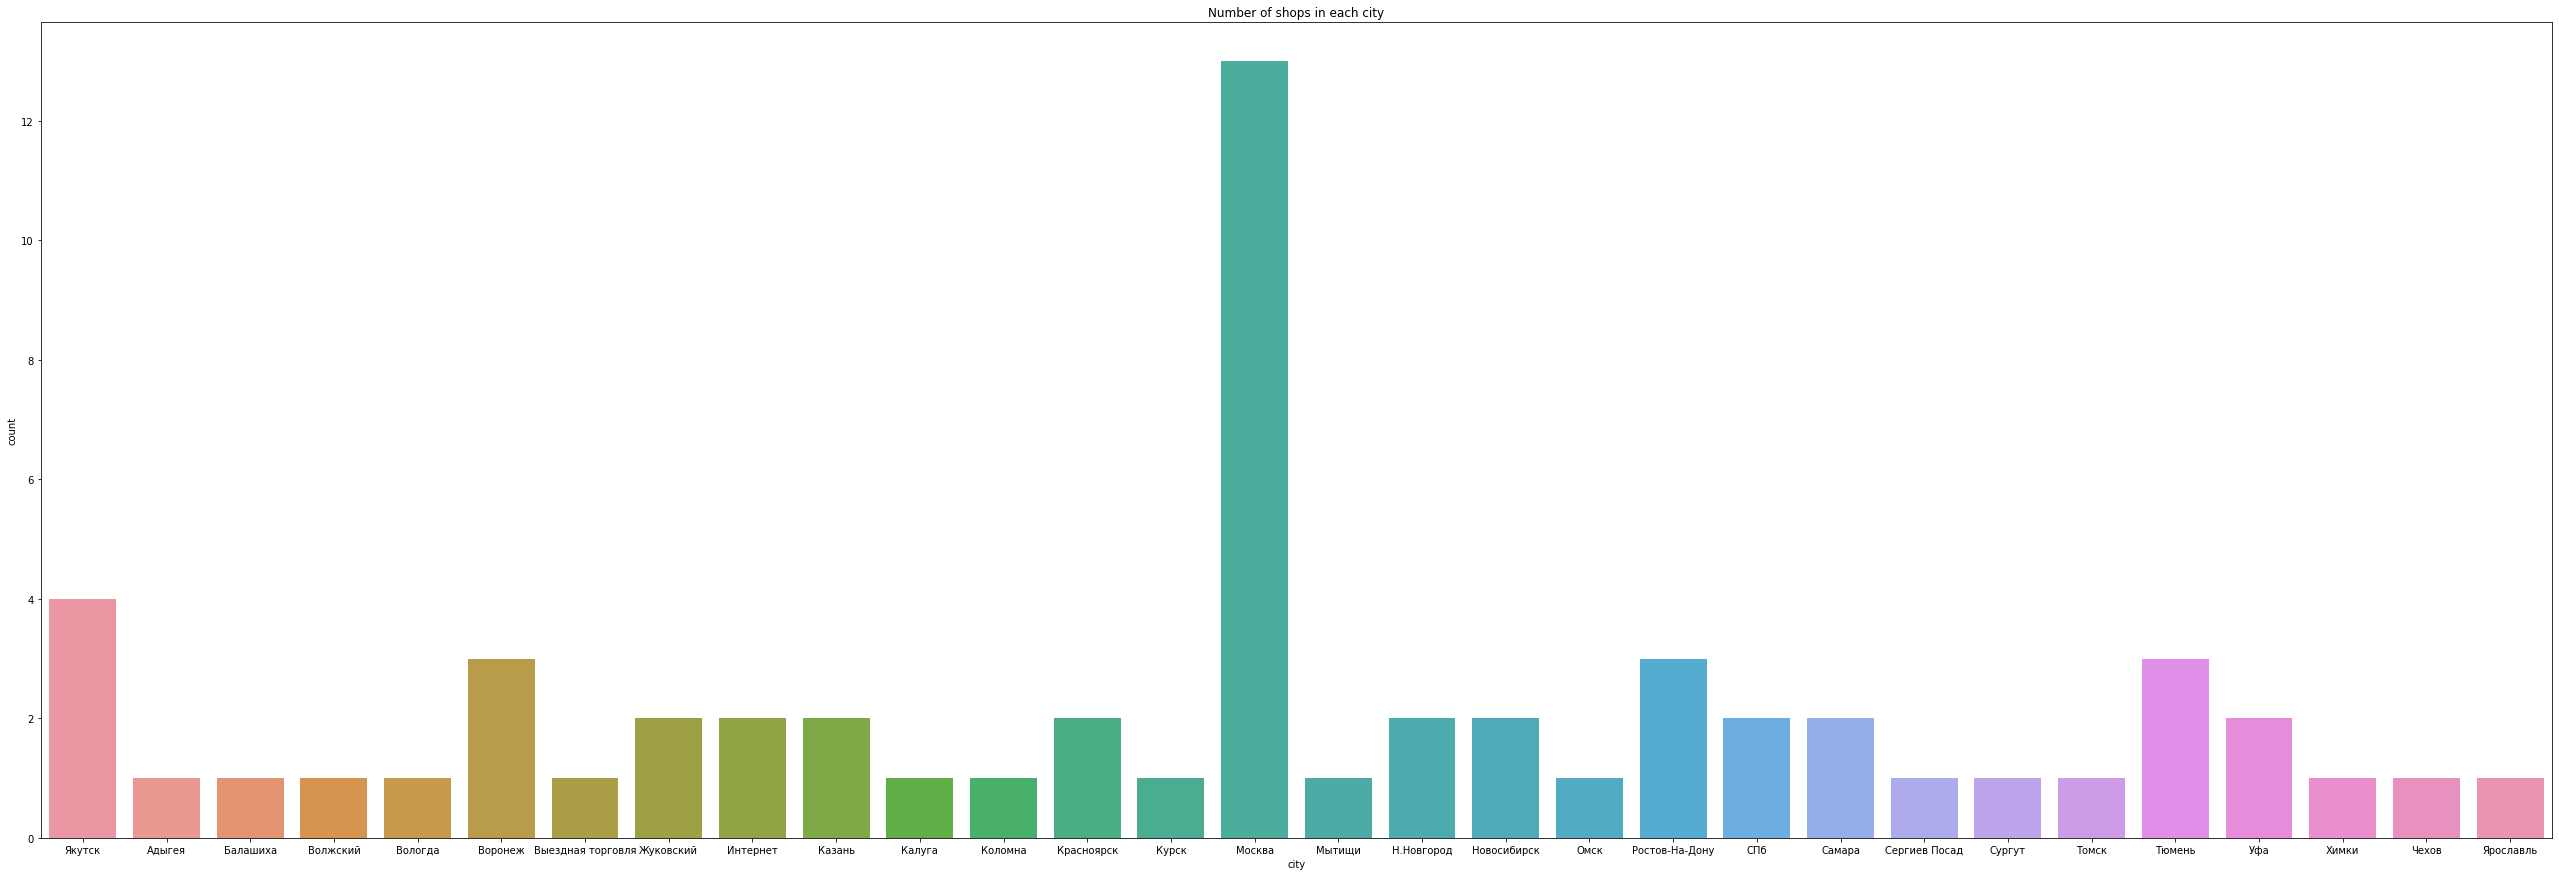

In [21]:
fig = plt.figure(figsize=(45, 15))
sns.countplot(x='city', data=shops)
plt.title('Number of shops in each city')
plt.show()

* As it was expected most shops are located in Moscow

* Let's check the most selling shops

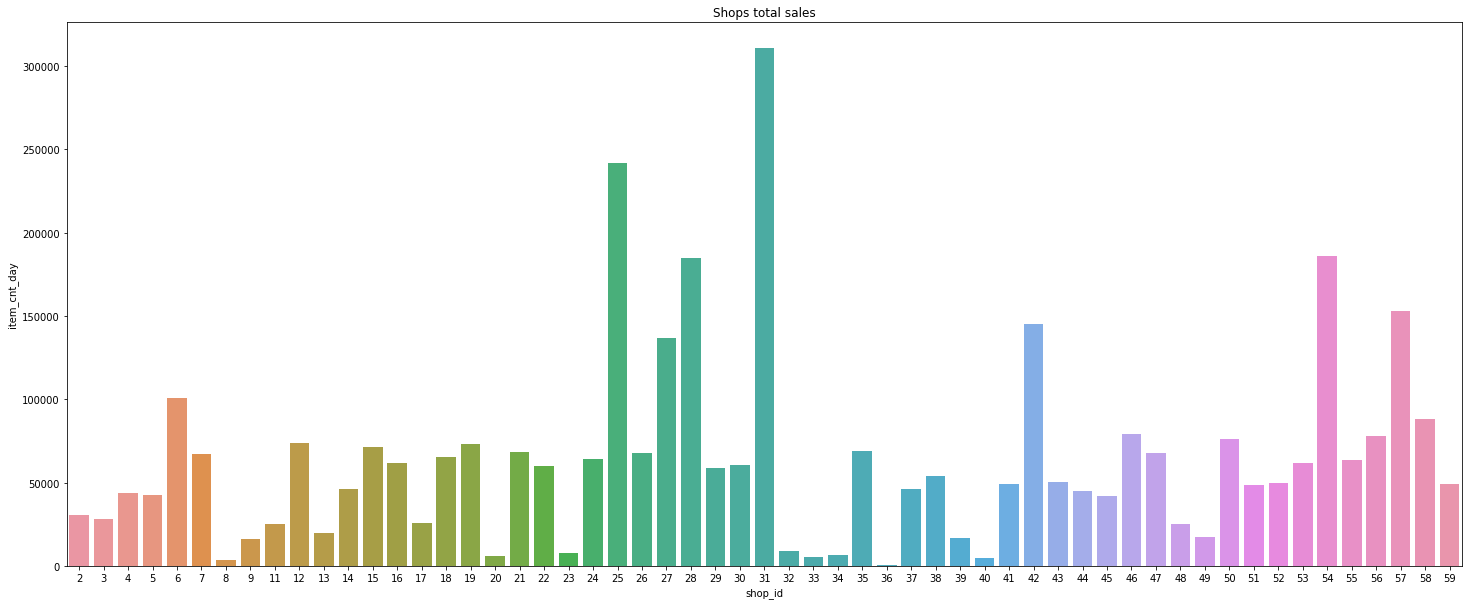

In [22]:
fig = plt.figure(figsize=(25, 10))
sns.barplot(x='shop_id',
            y='item_cnt_day',
            data=sales_train.groupby('shop_id').aggregate({'item_cnt_day' : 'sum'}).reset_index())
plt.title('Shops total sales')
plt.show()

* Most of the shops have simmilar sales amount (around 50000), but also there are several shops with much higher sales amount

### Sales Data

In [23]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [24]:
sales_train.shape

(2935843, 6)

* Checking outliers

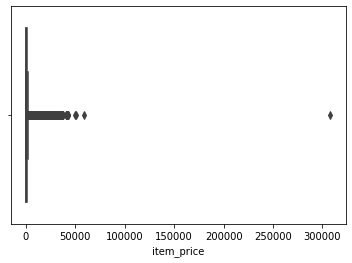

In [25]:
sns.boxplot(x=sales_train['item_price'])
plt.show()

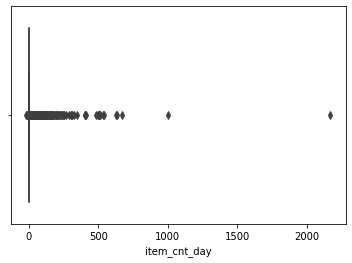

In [26]:
sns.boxplot(x=sales_train['item_cnt_day'])
plt.show()

* I will consider 'item_price' < 0 and > 50000 & 'item_cnt_day' < 0 and > 1000 as outliers and remove them

In [27]:
sales_train[(sales_train['item_price'] < 0) | (sales_train['item_price'] > 50000)]

date  date_block_num  shop_id  item_id  item_price  \
484682   15.05.2013               4       32     2973        -1.0   
885137   17.09.2013               8       12    11365     59200.0   
1163157  13.12.2013              11       12     6066    307980.0   
1488133  20.03.2014              14       25    13199     50999.0   

         item_cnt_day  
484682            1.0  
885137            1.0  
1163157           1.0  
1488133           1.0

In [28]:
sales_train[(sales_train['item_cnt_day'] < 0) | (sales_train['item_cnt_day'] > 1000)]

date  date_block_num  shop_id  item_id  item_price  \
2        05.01.2013               0       25     2552       899.0   
148      23.01.2013               0       25     2321       999.0   
175      07.01.2013               0       25     2199      1449.0   
807      02.01.2013               0       25     2330       599.0   
1041     13.01.2013               0       25     5034      1989.0   
...             ...             ...      ...      ...         ...   
2934237  26.10.2015              33       25     3917       449.0   
2934456  18.10.2015              33       25     4896      6398.0   
2935257  05.10.2015              33       25    10039       249.0   
2935637  16.10.2015              33       25     7893      2990.0   
2935773  07.10.2015              33       25     7087       999.0   

         item_cnt_day  
2                -1.0  
148              -1.0  
175              -1.0  
807              -1.0  
1041             -1.0  
...               ...  
2934237          -1.0  
2934456          -1.0  
2935257          -1.0  
2935637          -1.0  
2935773          -1.0  

[7357 rows x 6 columns]

In [29]:
def remove_outliers(df: pd.DataFrame, max_price: int, max_cnt: int):  
    df = df[df['item_price'] > 0]
    df = df[df['item_price'] < max_price]
    df = df[df['item_cnt_day'] > 0]
    df = df[df['item_cnt_day'] < max_cnt]
    return df


sales_train = remove_outliers(sales_train, 50000, 1000)

In [30]:
sales_train.date = pd.to_datetime(sales_train.date, format='%d.%m.%Y')

* The task is to predict total sales for the whole next month, so lets aggregate sales on month level

In [31]:
data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_cnt_day': 'sum',
                                                                                          'item_price': 'mean'})
data.head()

date_block_num  shop_id  item_id  item_cnt_day  item_price
0               0        2       27           1.0      2499.0
1               0        2       33           1.0       499.0
2               0        2      317           1.0       299.0
3               0        2      438           1.0       299.0
4               0        2      471           2.0       399.0

* Let's combine all potentialy necessary features in one dataframe

In [32]:
data = data.merge(items, on='item_id')
data = data.merge(item_categories, on='item_category_id')
data = data.merge(shops, on='shop_id')
data.sample(5)

date_block_num  shop_id  item_id  item_cnt_day  item_price  \
1201950              10       52    17346           4.0       399.0   
28586                14       11     9781           1.0       268.0   
555621               17       53     4960           1.0       899.0   
1457522               7       46     7907           1.0      1990.0   
907666               21       17     2416           1.0       449.0   

                                                 item_name  item_category_id  \
1201950                                 ПРИЗРАЧНЫЙ ПАТРУЛЬ                40   
28586                                       ВЕЛИКИЙ ГЭТСБИ                40   
555621   Move Фитнес (Essentials) (только для PS Move) ...                19   
1457522     XBOX360WIRELESSSPEEDWHEEL XBOX 360 (2ZJ-00003)                 6   
907666   Counter Strike. Global Offensive [PC, Jewel, р...                30   

        item_category_name    item_sub_category  \
1201950               Кино                  DVD   
28586                 Кино                  DVD   
555621                Игры                  PS3   
1457522         Аксессуары             XBOX 360   
907666             Игры PC  Стандартные издания   

                             shop_name           city  
1201950           Уфа ТК "Центральный"            Уфа  
28586       Жуковский ул. Чкалова 39м²      Жуковский  
555621                Уфа ТЦ "Семья" 2            Уфа  
1457522          Сергиев Посад ТЦ "7Я"  Сергиев Посад  
907666   Красноярск ТЦ "Взлетка Плаза"     Красноярск

In [33]:
data.shape

(1729502, 11)

* Total sales in each month

Text(0.5, 1.0, 'Month total sales')

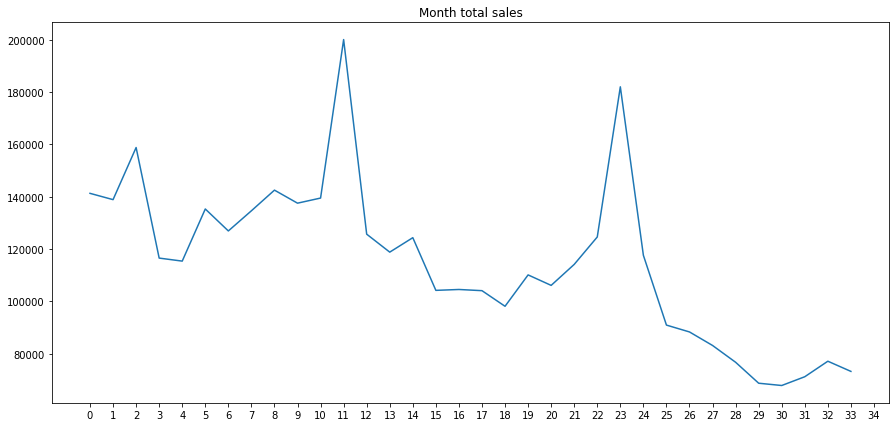

In [38]:
fig = plt.figure(figsize=(15, 7))
plt.plot(data.groupby(['date_block_num'])['item_cnt_day'].sum())
plt.xticks(np.arange(35))
plt.title('Month total sales')

* As we can see there are two 'peaks' in 11 and 23 months. These months are both December, so it's Christmas and New Year time

* Let's check sales distribution depending on 'item_id', 'item_category_id' and 'shop_id' features

Text(0.5, 1.0, 'Items sales distribution')

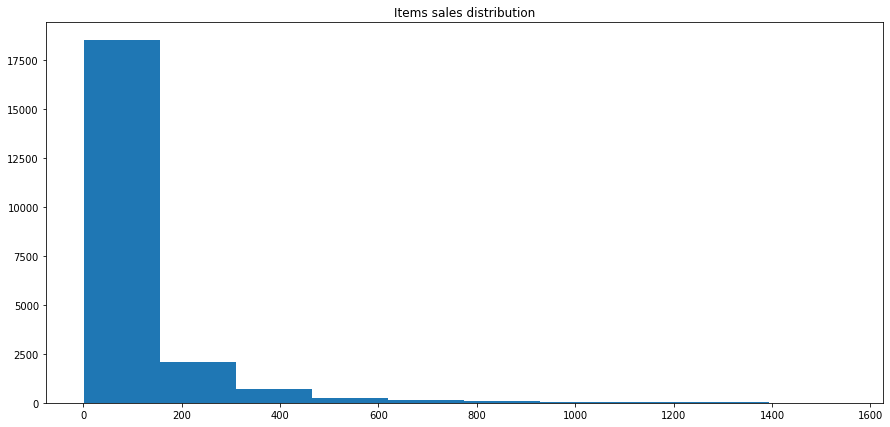

In [39]:
fig = plt.figure(figsize=(15, 7))
plt.hist(data.groupby(['item_id']).count()['item_cnt_day'])
plt.title('Items sales distribution')

* As we can see, most items are sold no more than 400-600 times totally

Text(0.5, 1.0, 'Item categories sales distribution')

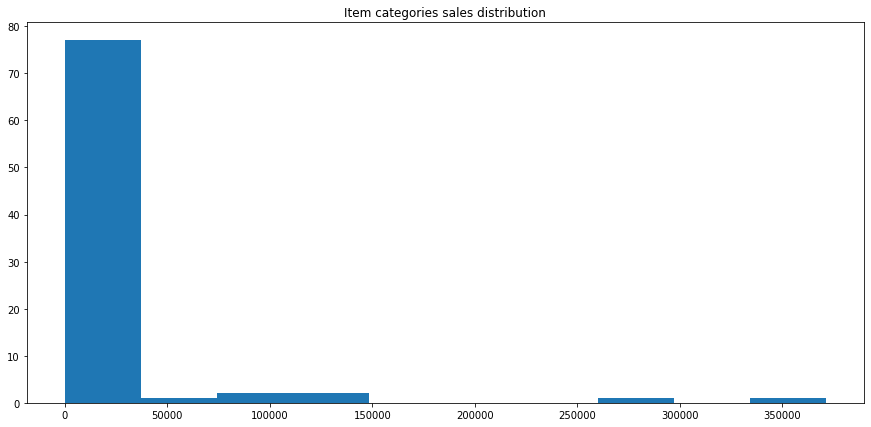

In [40]:
fig = plt.figure(figsize=(15, 7))
plt.hist(data.groupby(['item_category_id']).count()['item_cnt_day'])
plt.title('Item categories sales distribution')

Text(0.5, 1.0, 'Shops sales distribution')

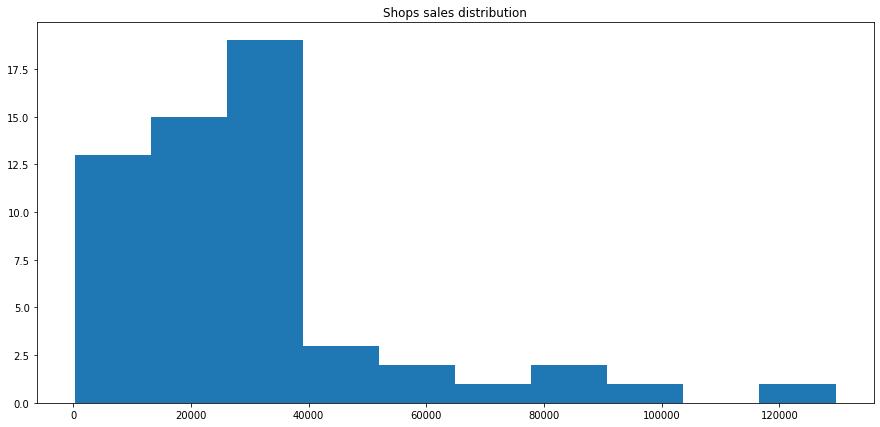

In [41]:
fig = plt.figure(figsize=(15, 7))
plt.hist(data.groupby(['shop_id']).count()['item_cnt_day'])
plt.title('Shops sales distribution')

* Almost the same distributions have 'item_category_id' and 'item_id' features. Most shops sales are no more than 40000

* Let's check last sale date at each shop and of each item and decide whether it's closed/outdated or not

In [42]:
last_shop = pd.DataFrame(sales_train.groupby('shop_id')['date'].max()).sort_values('date').reset_index()
last_shop[last_shop.date <= pd.Timestamp(2015, 6, 30)]

shop_id       date
0         8 2013-03-24
1        23 2013-04-28
2        32 2013-07-03
3        13 2014-08-09
4        17 2015-01-18
5        43 2015-01-25
6        40 2015-01-29
7        30 2015-02-18
8        33 2015-03-18
9        54 2015-04-06
10       29 2015-05-28

In [43]:
last_item = pd.DataFrame(sales_train.groupby('item_id')['date'].max()).sort_values('date').reset_index()
last_item

item_id       date
0         9685 2013-01-01
1        20481 2013-01-01
2         9777 2013-01-01
3         6469 2013-01-01
4         3766 2013-01-01
...        ...        ...
21797    17322 2015-10-31
21798     7834 2015-10-31
21799     3217 2015-10-31
21800    13234 2015-10-31
21801     4573 2015-10-31

[21802 rows x 2 columns]

In [44]:
not_sold = pd.DataFrame(data.groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()).reset_index()
not_sold = not_sold[not_sold.item_cnt_day == 0]
not_sold.shape

(0, 3)

In [46]:
items.shape

(22170, 3)

* Let's check if there are items that haven't been sold at all

In [47]:
not_sold_items = pd.DataFrame(pd.concat([last_item.item_id, items.item_id]).drop_duplicates(keep=False))
not_sold_items

item_id
83          83
140        140
168        168
173        173
204        204
...        ...
21974    21974
21975    21975
22022    22022
22035    22035
22137    22137

[368 rows x 1 columns]

* Let's check whether these items are present it test set

In [48]:
not_sold_items.merge(test.item_id.drop_duplicates(), how ='inner', on='item_id')

item_id
0         83
1        140
2        168
3        173
4        204
..       ...
358    21974
359    21975
360    22022
361    22035
362    22137

[363 rows x 1 columns]

In [49]:
not_sold_items.to_csv('../data/new_items.csv', index=False)

### Correlations

* Let's check correlation between price and sales amount

In [50]:
sales_train[['item_cnt_day','item_price']].corr()

item_cnt_day  item_price
item_cnt_day      1.000000    0.014444
item_price        0.014444    1.000000

In [51]:
data[['item_cnt_day','item_price']].corr()

item_cnt_day  item_price
item_cnt_day      1.000000    0.025784
item_price        0.025784    1.000000

* As we can see there is almost no correlation between sales amount and price (probably there is nonlinear dependency)

* Let's check correlation between last month sales and previous ones

In [52]:
last_month = data[data.date_block_num == 33][['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
lag_months = [1, 2, 3, 12]
lags = pd.DataFrame()
for lag in lag_months:
    cur_lag = data[data.date_block_num == 33 - lag][['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
    cur_lag = cur_lag.rename({'item_cnt_day': 'item_cnt_last_{}'.format(lag),
                              'item_price': 'item_price_last_{}'.format(lag)}, axis=1)

    last_month = last_month.merge(cur_lag.drop(columns='date_block_num'), how='left',
                                on=['shop_id', 'item_id'])

lags = last_month.fillna(0)
lags.drop(columns=['date_block_num', 'shop_id', 'item_id']).corr().iloc[:, 0]

item_cnt_day        1.000000
item_cnt_last_1     0.710230
item_cnt_last_2     0.724355
item_cnt_last_3     0.691568
item_cnt_last_12    0.719456
Name: item_cnt_day, dtype: float64

* Let's check correlation between last month sales and ranges of previous ones

In [53]:
last_month = data[data.date_block_num == 33][['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
lag_months = [3, 6, 12]
lags = pd.DataFrame()
for lag in lag_months:
    cur_lag = data[(33 - lag <= data.date_block_num) & (data.date_block_num < 33)].groupby(['date_block_num', 'shop_id',
                                                                                            'item_id'],
                                                    as_index=False).agg({'item_cnt_day': 'sum'})
    cur_lag = cur_lag.rename({'item_cnt_day': 'item_cnt_last_{}'.format(lag),
                              'item_price': 'item_price_last_{}'.format(lag)}, axis=1)

    last_month = last_month.merge(cur_lag.drop(columns='date_block_num'), how='left',
                                on=['shop_id', 'item_id'])

lags = last_month.fillna(0)
lags.drop(columns=['date_block_num', 'shop_id', 'item_id']).corr().iloc[:, 0]

item_cnt_day        1.000000
item_cnt_last_3     0.911189
item_cnt_last_6     0.770574
item_cnt_last_12    0.736020
Name: item_cnt_day, dtype: float64

* In both cases with single months and ranges of them there is high correlation between sales amount

### Seasonality

* Let's check sales of each item in autumn

In [54]:
autumn = data[data.date_block_num.isin([8,9,10,20,21,22,32,33])]
not_autumn = pd.concat([data, autumn]).drop_duplicates(keep=False)
print((len(data), len(autumn), len(not_autumn)))

(1729502, 369218, 1360284)


In [55]:
diff = pd.DataFrame(pd.concat([not_autumn.item_id.drop_duplicates(), autumn.item_id.drop_duplicates()]).drop_duplicates(keep=False))
autumn = diff.merge(autumn.item_id.drop_duplicates(), how ='inner', on='item_id')
autumn

item_id
0        3736
1        1499
2        3350
3        4839
4       13457
...       ...
1274     5386
1275     4931
1276    13091
1277    13094
1278    13092

[1279 rows x 1 columns]

In [56]:
autumn.to_csv('../data/autumn.csv', index=False)

In [57]:
temp = data[data.date_block_num.isin([8,9,10,20,21,22,32,33])]['item_id'].drop_duplicates()
not_autumn = pd.DataFrame(pd.concat([temp, data.item_id.drop_duplicates()]).drop_duplicates(keep=False))
not_autumn

item_id
175         3687
178         3704
226         4229
235         4476
407        11392
...          ...
1729461     3638
1729462     4729
1729463     7921
1729464     3872
1729477     5230

[5131 rows x 1 columns]

* autumn - items sold only in autumn
* not_autumn - items not sold in autumn at all

* Let's check whether these items are present in test set

In [58]:
not_autumn.merge(test.item_id.drop_duplicates(), how ='inner', on='item_id')

item_id
0      20919
1       3484
2      17152
3      10126
4      17566
..       ...
115     3414
116     3231
117    19442
118    19427
119      653

[120 rows x 1 columns]

In [59]:
not_autumn.to_csv('../data/not_autumn.csv', index=False)

### Feature clustering

In [60]:
class FeatureClustering:
    def __init__(self, feat: str, df: pd.DataFrame, n_month: int):  
        self.feat = feat
        self.feats = list(sorted(df[feat].unique()))
        self.n_month = n_month
    
    def plot_graphs(self, df: pd.DataFrame):
        fig = plt.figure(figsize=(20, 70))
        for i in range(len(self.feats)):
            plt.subplot(17, 5, i + 1)
            temp = []
            for month in range(self.n_month):
                temp += [df[(df[self.feat] == self.feats[i]) & (df.date_block_num == month)]['item_cnt_day'].sum()]
            plt.plot(range(self.n_month), temp)
            plt.title('Month {} {} sales'.format(self.feat, self.feats[i]))
            
    def create_data(self, df: pd.DataFrame, scaler):
        feats_cluster = []
        for feat in self.feats:
            temp = [feat]
            for month in range(self.n_month):
                temp += [df[(df[self.feat] == feat) & (df.date_block_num == month)]['item_cnt_day'].sum()]
            feats_cluster.append(np.array(temp))
        self.feats_cluster = pd.DataFrame(np.vstack(feats_cluster), columns=['{}'.format(self.feat)] + ['{}'.format(i) for i in range(self.n_month)])
        self.feats_scaled = scaler.fit_transform(self.feats_cluster.iloc[:, 1:].T).T
        
    def show_metrics(self):
        distortions = []
        silhouette = []
        K = range(1, 10)
        for k in K:
            kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
            kmeanModel.fit(self.feats_scaled)
            distortions.append(kmeanModel.inertia_)
            if k > 1:
                silhouette.append(silhouette_score(self.feats_scaled, kmeanModel.labels_))

        plt.figure(figsize=(10,4))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(K[1:], silhouette, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette')
        plt.show()
        
    def fit_and_plot_centres(self, n_clusters: int):
        self.n_clusters = n_clusters
        self.model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=100)
        self.model.fit(self.feats_scaled)

        plt.figure(figsize=(12, 8))
        for cluster_number in range(n_clusters):
            plt.plot(self.model.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
        plt.title("Cluster centroids")
        plt.legend()
        plt.show()
        
    def predict(self):
        return self.model.predict(self.feats_scaled)
    
    def plot_clusters(self):
        def plot(current_cluster):
            fig, ax = plt.subplots(
                int(np.ceil(current_cluster.shape[0] / 4)),
                4,
                figsize=(15, 3 * int(np.ceil(current_cluster.shape[0] / 4)))
            )
            fig.autofmt_xdate(rotation=45)
            ax = ax.reshape(-1)

            for index, (_, row) in enumerate(current_cluster.iterrows()):
                ax[index].plot(row.iloc[5: -1])
                ax[index].set_title(f"{row[self.feat]}")
                plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()
        
        self.feats_cluster['cluster'] = self.predict()
        for cluster in range(self.n_clusters):
            print("=================================================================================")
            print(f"                          Cluster number: {cluster}")
            print("=================================================================================")
            plot(self.feats_cluster[self.feats_cluster.cluster == cluster])

* Category

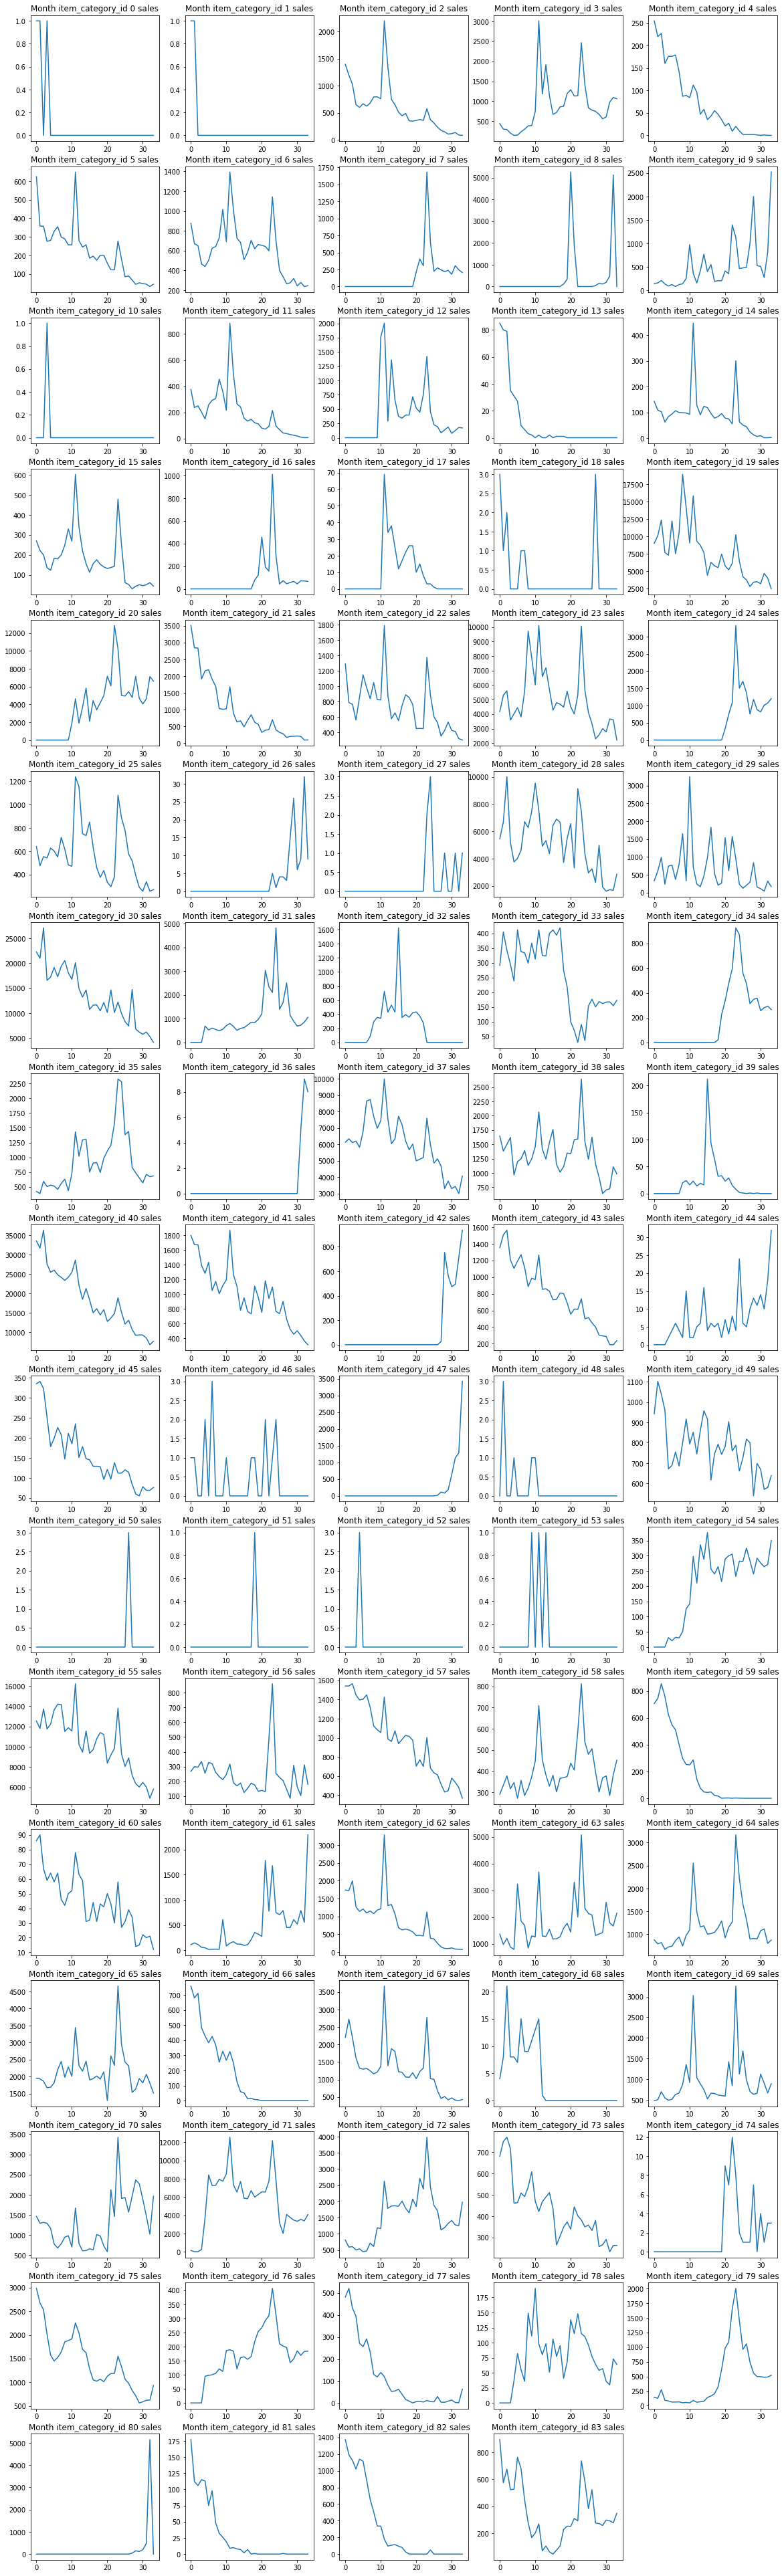

In [46]:
cat_sales = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
fc = FeatureClustering('item_category_id', cat_sales, 34)
fc.plot_graphs(cat_sales)

In [47]:
zero_cats = [0, 1, 4, 10, 17, 13, 27, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 18, 32, 80, 81, 82]
for zc in zero_cats:
    cat_sales.drop(cat_sales[cat_sales['item_category_id'] == zc].index, inplace=True)
cat_sales

date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-02               0       59    22154      999.00   
1       2013-01-03               0       25     2552      899.00   
2       2013-01-05               0       25     2552      899.00   
3       2013-01-06               0       25     2554     1709.05   
4       2013-01-15               0       25     2555     1099.00   
...            ...             ...      ...      ...         ...   
2935837 2015-10-10              33       25     7409      299.00   
2935838 2015-10-09              33       25     7460      299.00   
2935839 2015-10-14              33       25     7459      349.00   
2935840 2015-10-22              33       25     7440      299.00   
2935841 2015-10-03              33       25     7460      299.00   

         item_cnt_day  item_category_id  
0                 1.0                37  
1                 1.0                58  
2                 0.0                58  
3                 1.0                58  
4                 1.0                56  
...               ...               ...  
2935837           1.0                55  
2935838           1.0                55  
2935839           1.0                55  
2935840           1.0                57  
2935841           1.0                55  

[2909197 rows x 7 columns]

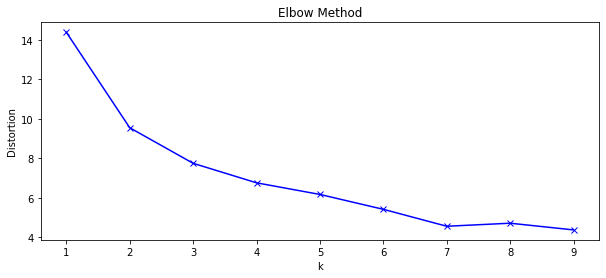

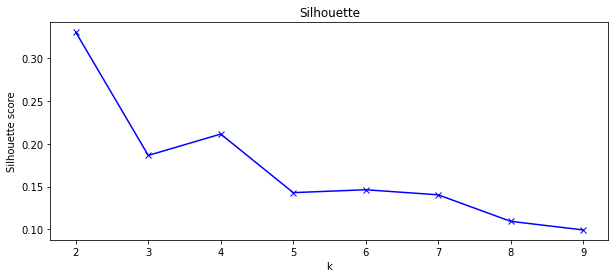

In [52]:
fc = FeatureClustering('item_category_id', cat_sales, 34)
fc.create_data(cat_sales, StandardScaler())
fc.show_metrics()

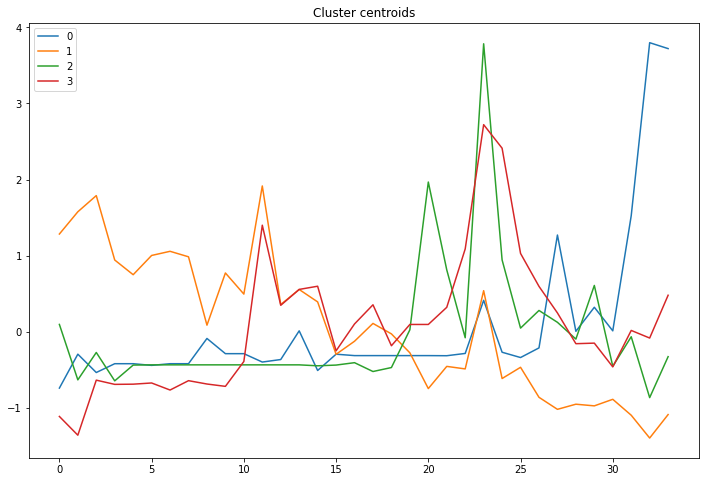

In [53]:
fc.fit_and_plot_centres(n_clusters=4)

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 62 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


                          Cluster number: 0


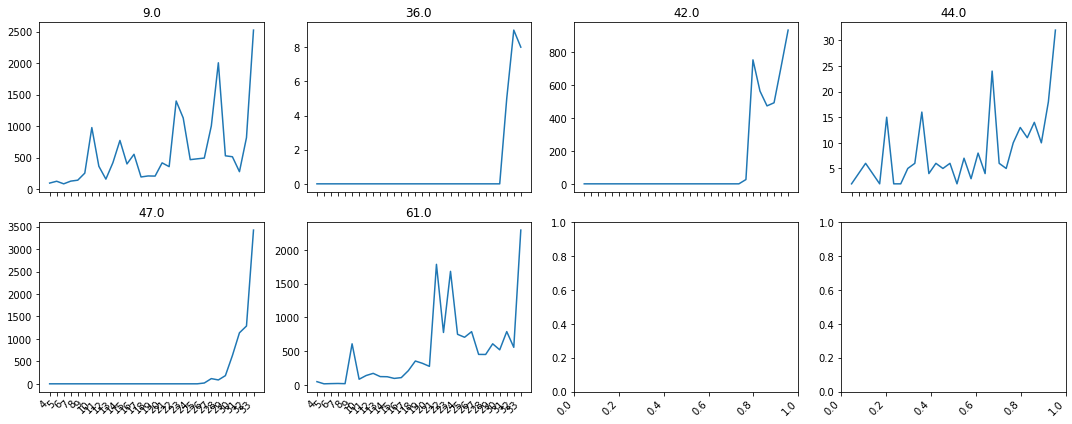

                          Cluster number: 1


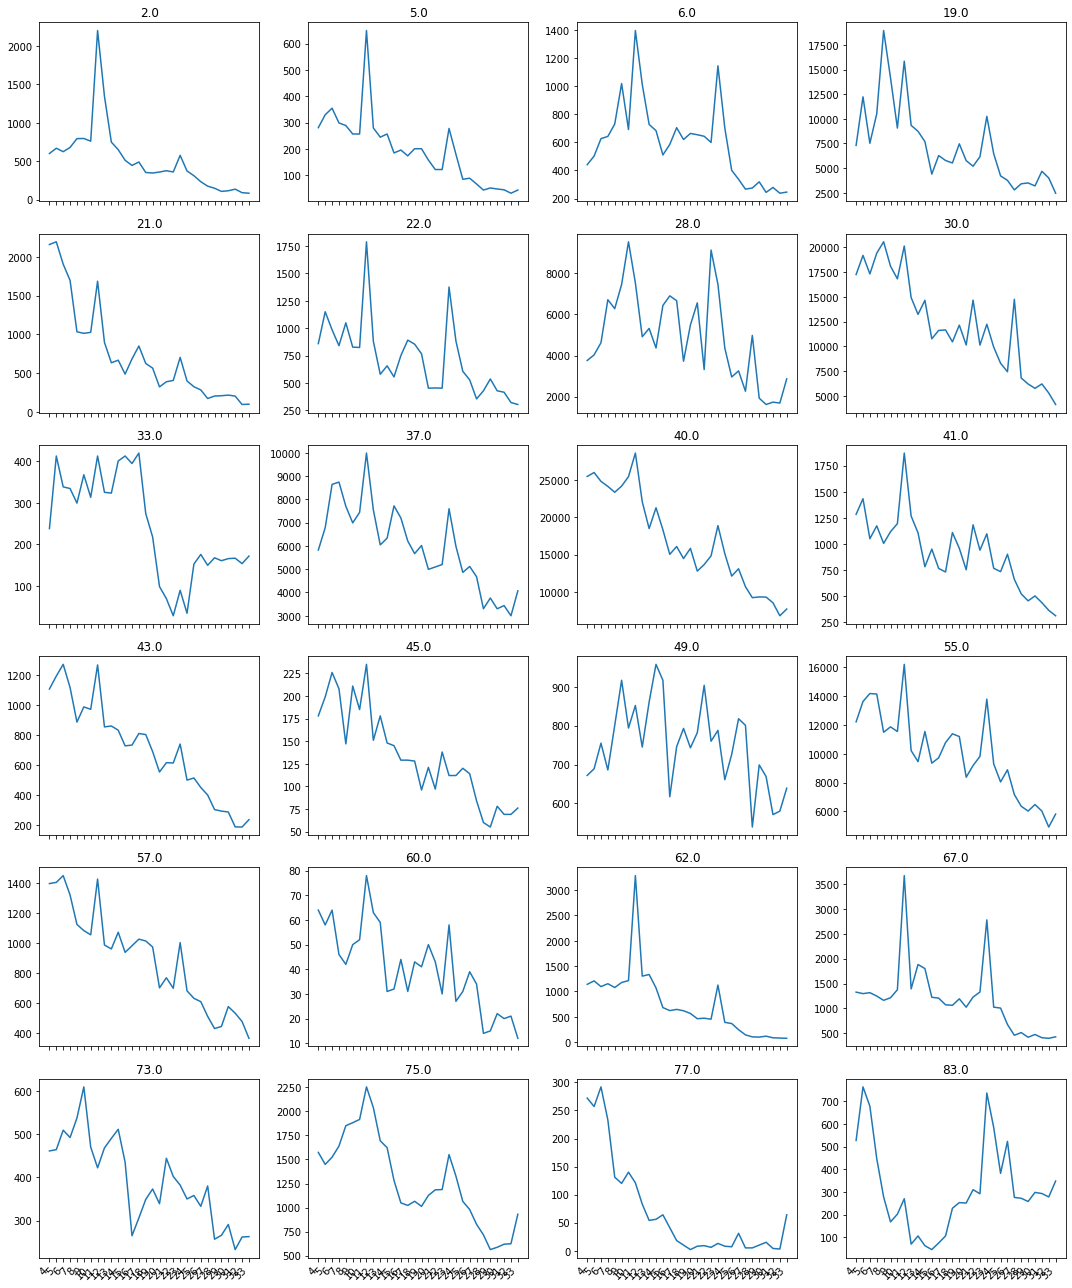

                          Cluster number: 2


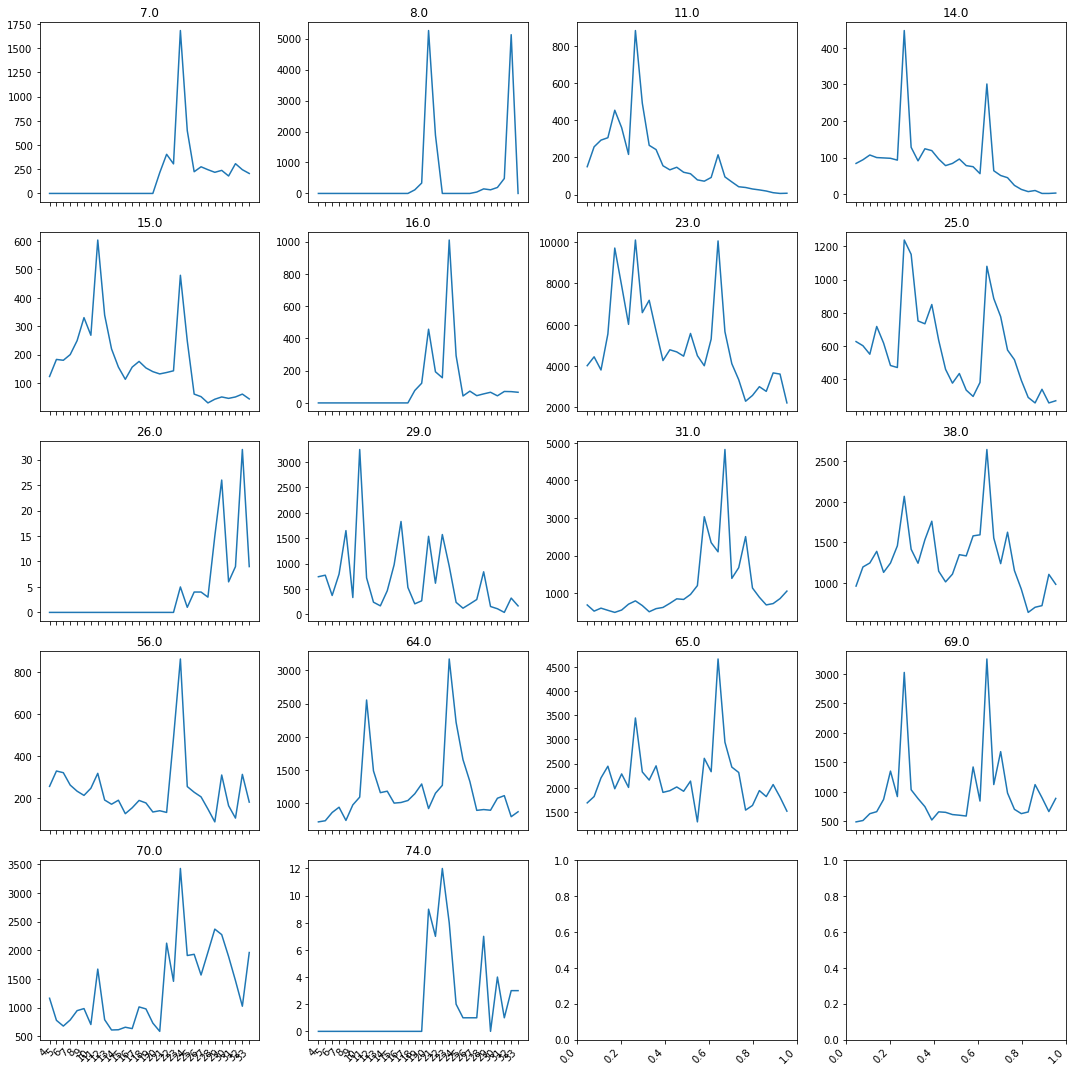

                          Cluster number: 3


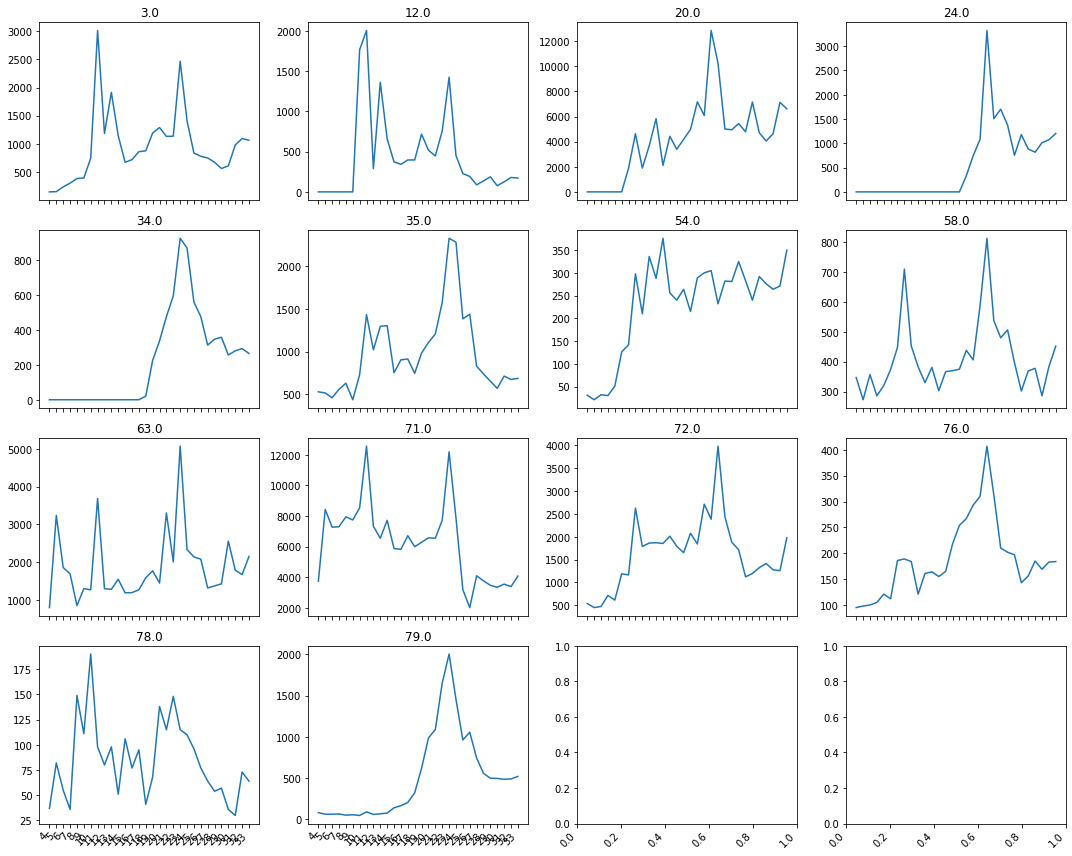

In [54]:
fc.plot_clusters()

* Shops

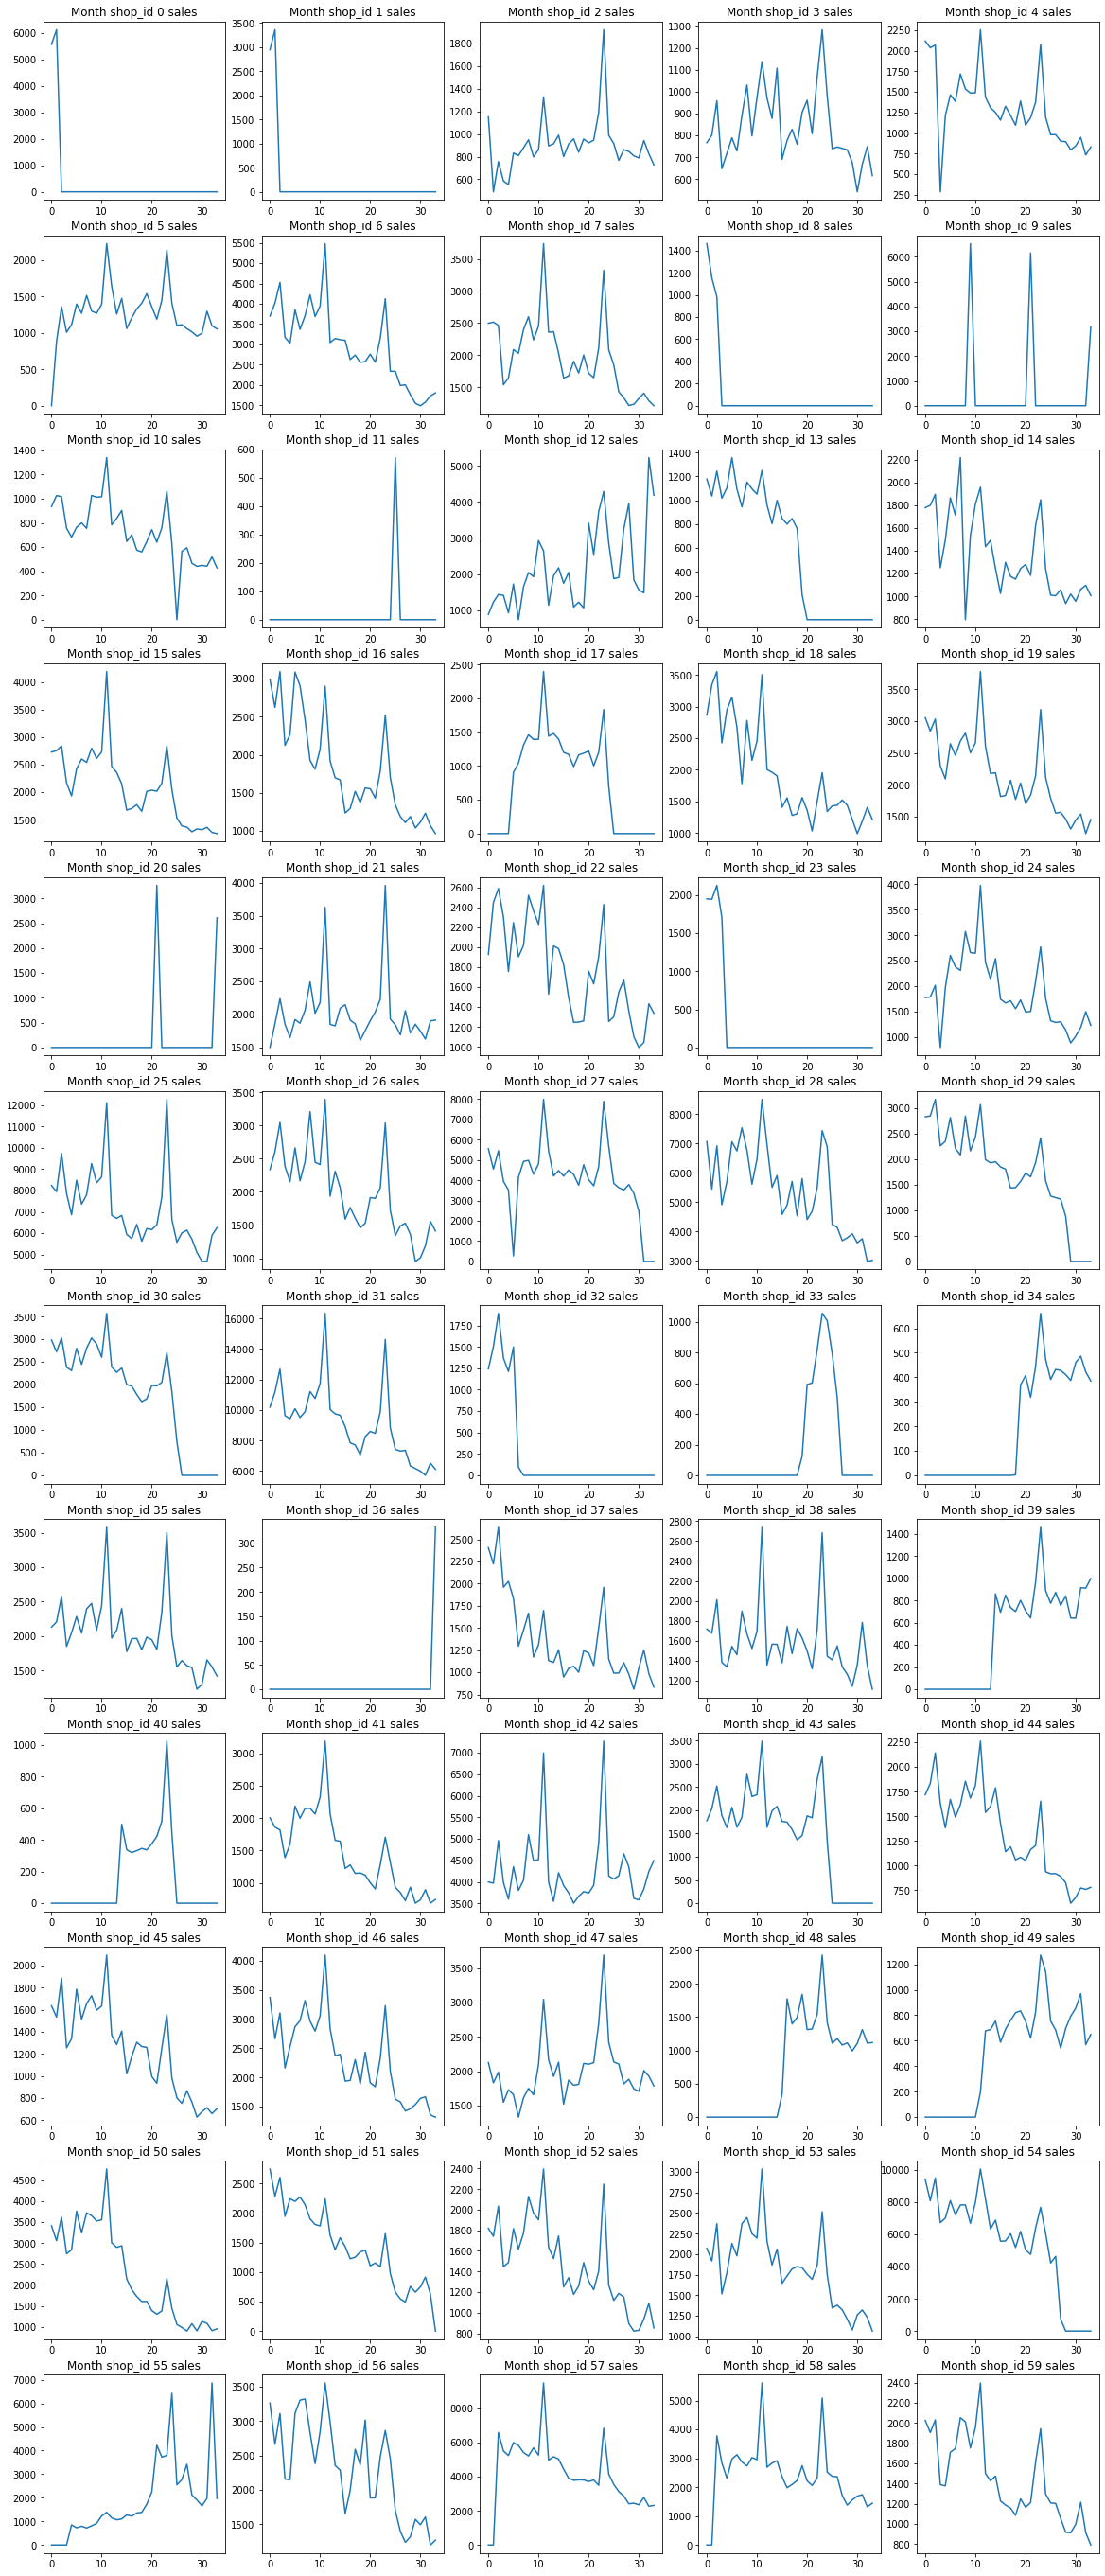

In [58]:
shops_sales = pd.DataFrame(sales_train)
fc = FeatureClustering('shop_id', shops_sales, 34)
fc.plot_graphs(shops_sales)

In [59]:
zero_shops = [0, 1, 8, 11, 13, 17, 23, 32, 33]
for zs in zero_cats:
    shops_sales.drop(shops_sales[shops_sales['shop_id'] == zs].index, inplace=True)
shops_sales

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1       2013-01-03               0       25     2552      899.00           1.0
2       2013-01-05               0       25     2552      899.00           0.0
3       2013-01-06               0       25     2554     1709.05           1.0
4       2013-01-15               0       25     2555     1099.00           1.0
5       2013-01-10               0       25     2564      349.00           1.0
...            ...             ...      ...      ...         ...           ...
2935837 2015-10-10              33       25     7409      299.00           1.0
2935838 2015-10-09              33       25     7460      299.00           1.0
2935839 2015-10-14              33       25     7459      349.00           1.0
2935840 2015-10-22              33       25     7440      299.00           1.0
2935841 2015-10-03              33       25     7460      299.00           1.0

[2303847 rows x 6 columns]

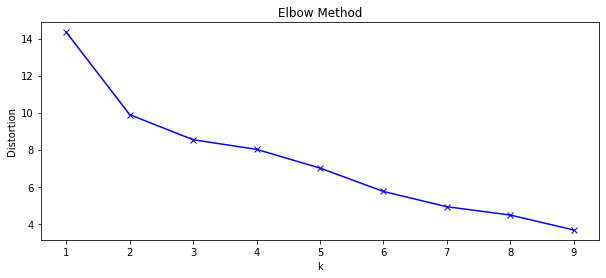

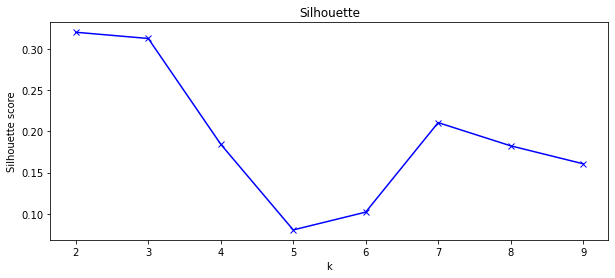

In [60]:
fc = FeatureClustering('shop_id', shops_sales, 34)
fc.create_data(shops_sales, StandardScaler())
fc.show_metrics()

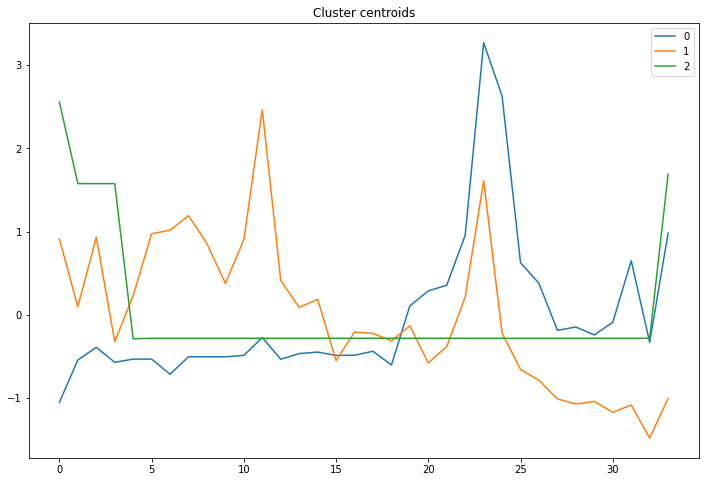

In [69]:
fc.fit_and_plot_centres(n_clusters=3)

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 43 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


                          Cluster number: 0


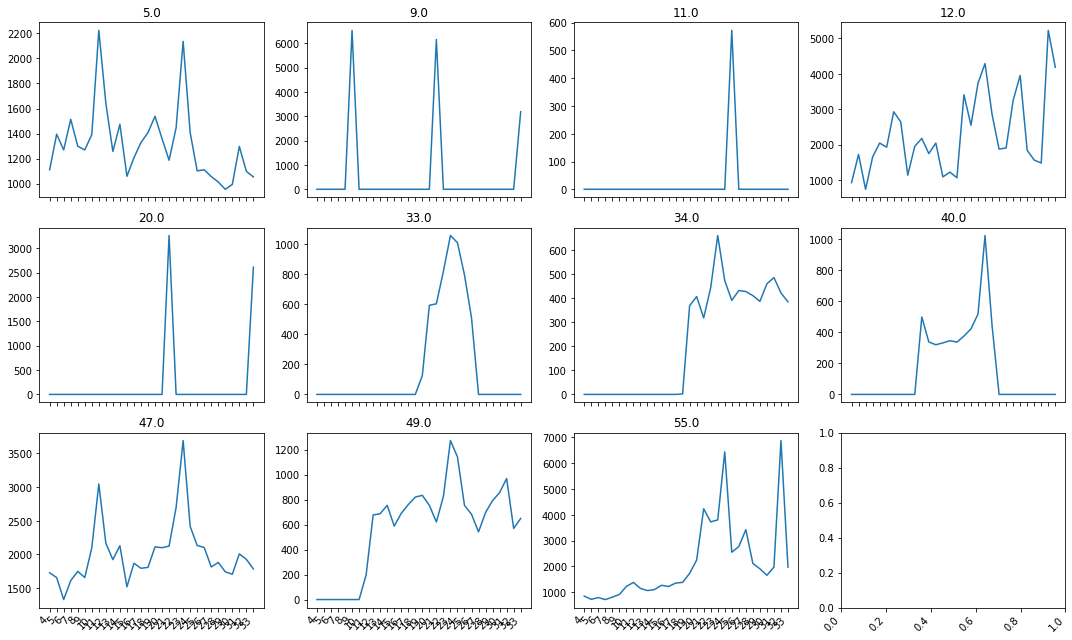

                          Cluster number: 1


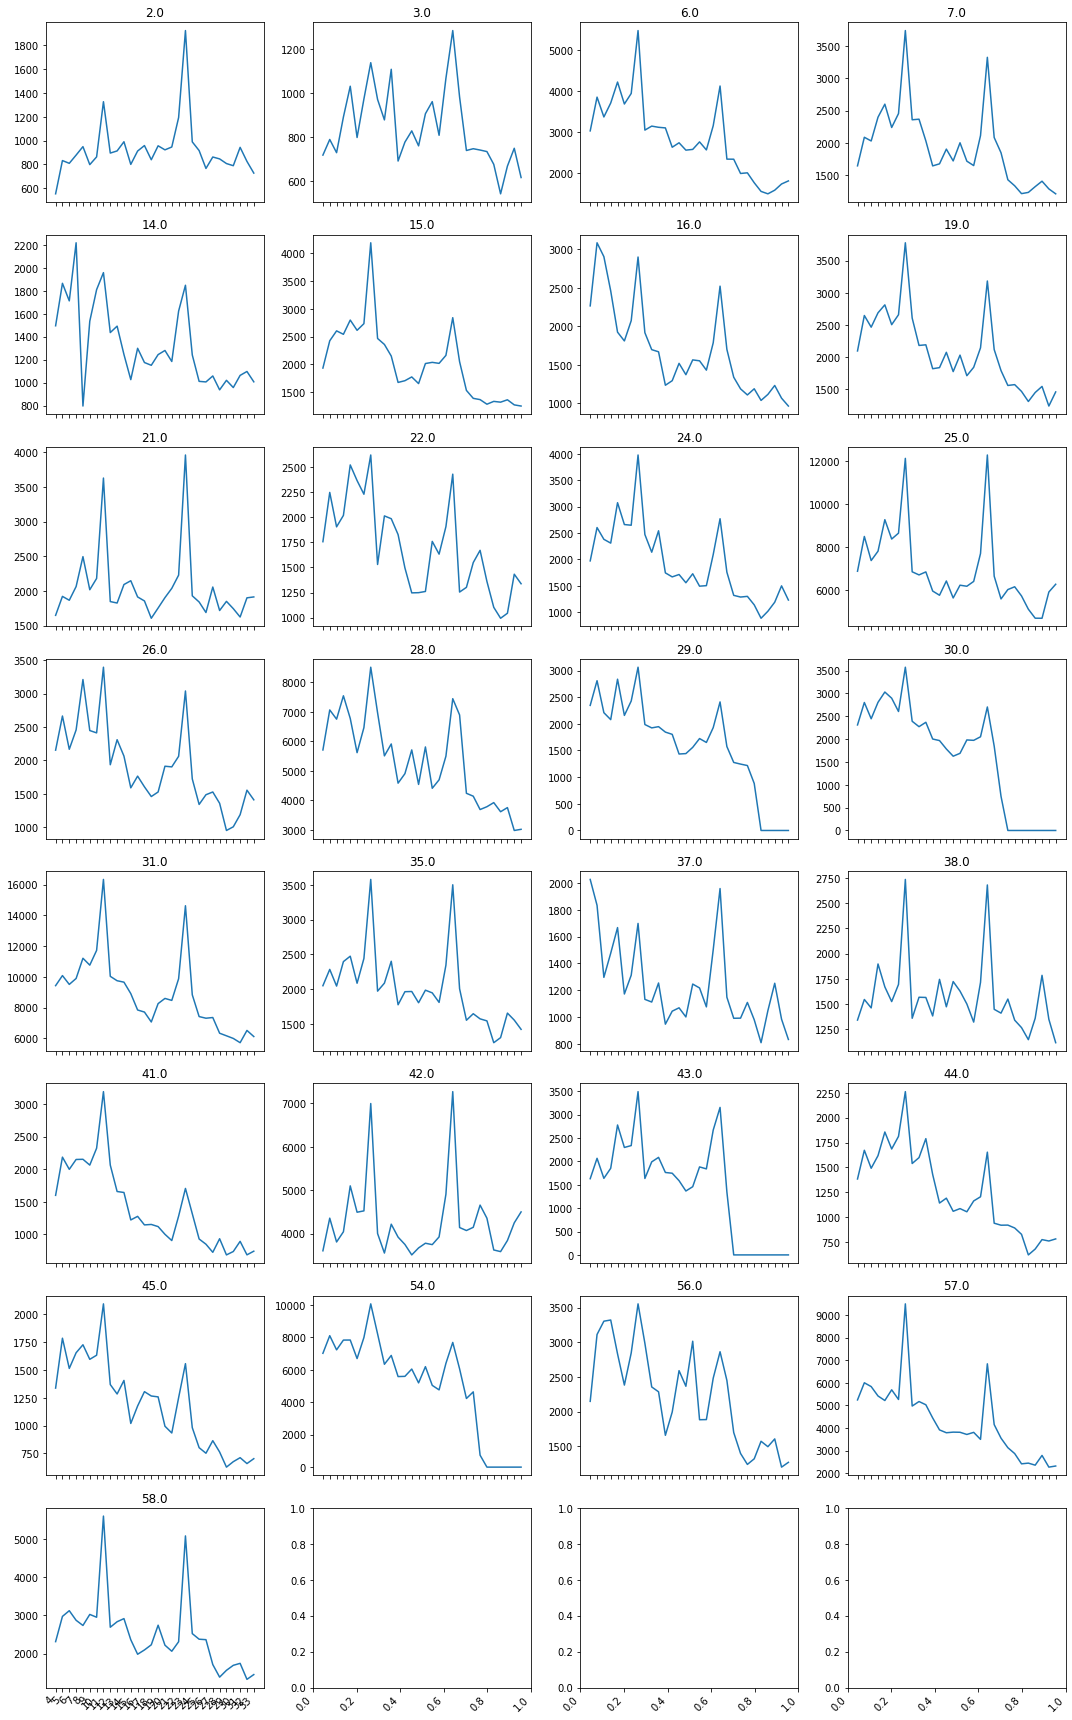

                          Cluster number: 2


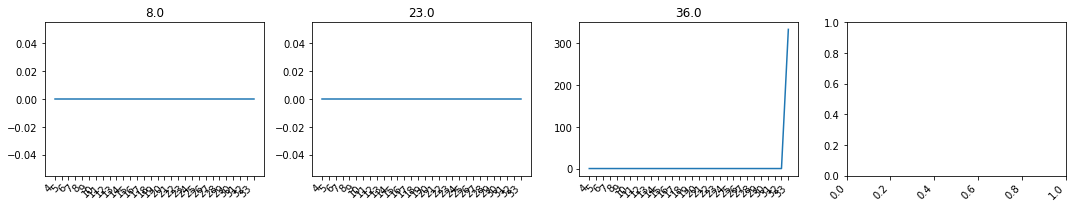

In [70]:
fc.plot_clusters()

* As we can see we can cluster these timeseries by category and shop feature. The suitable number of clusters can be determined via elbow method and silhouette score

* Let's examine how did the price change in each category

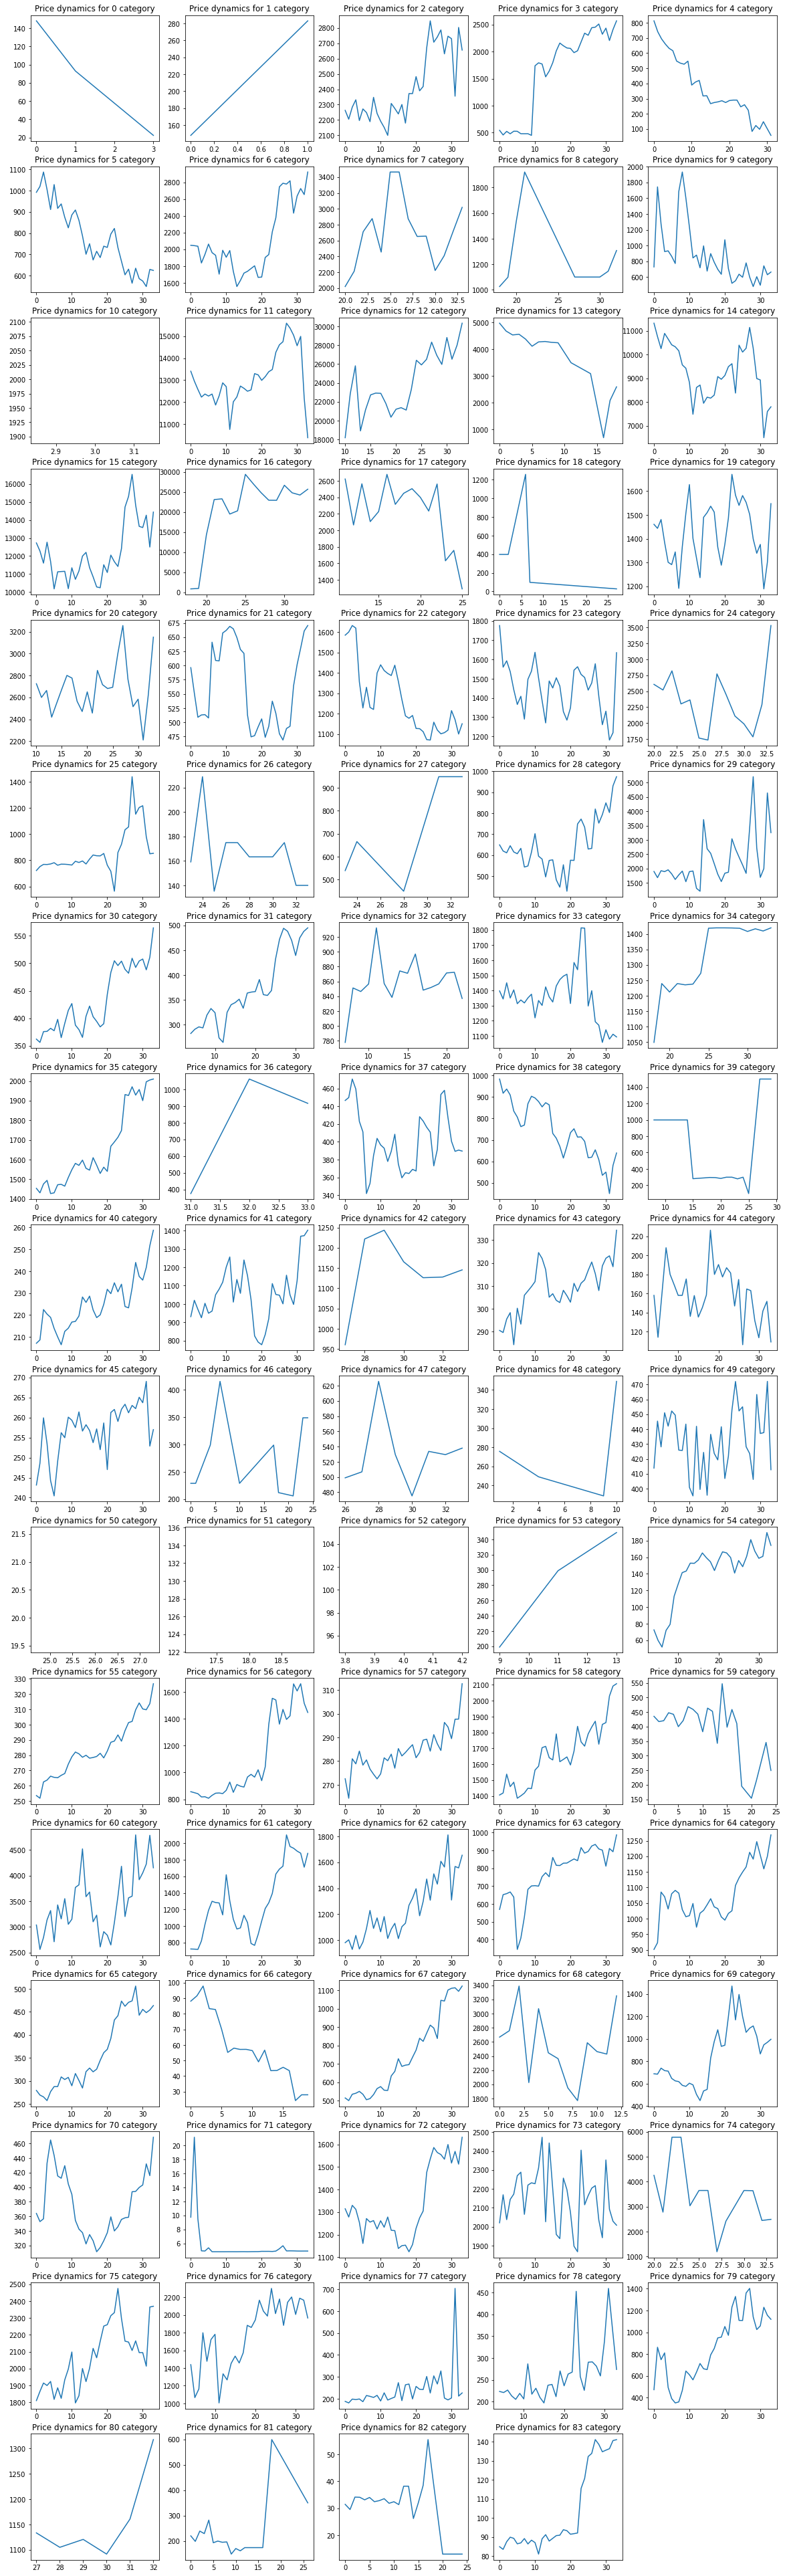

In [47]:
cats = sorted(data.item_category_id.unique())
fig = plt.figure(figsize=(20, 70))
for i in range(len(cats)):
    plt.subplot(17, 5, i + 1)
    plt.plot(data[data.item_category_id == cats[i]].groupby(['date_block_num'])['item_price'].mean())
    plt.title('Price dynamics for {} category'.format(cats[i]))

### Summary

* All dataframes don't have missing values
* Only sales_train dataframe contains 6 duplicates, the others do not
* Shops dataframe has 3 almost equal shop names - can be considered as duplicates as well
* Features 'item_price' and 'item_cnt_day' contain outliers. Examples with 'item_price' < 0 and > 50000 and with 'item_cnt_day' < 0 and > 1000 were considered as outliers and removed
* Only 9 categoties represent most of the total sales amount
* City feature was extracted from 'shop_name' feature, most shops are located in Moscow
* Most shops have simmilar sales amount (around 50000), but also there are several shops with much higher sales amount
* There are two 'peaks' in total sales in each month - both are in December (holidays time)
* All total sales by 'item_id', 'item_category_id', 'shop_id' distributions have peaks until some value (values) and highly remind Pareto distribution
* There are 363 new items in test set that haven't been sold yet
* There is almost no correlation between sales amount and price (probably there is nonlinear dependency)
* There is high correlation between last month sales amount and the previous months sales amount as well as previous ranges of months sales
* Seasonality was checked - items that are not sold in autumn were extracted
* Feature clustering for 'item_category_id' and 'shop_id' features was implemented using DWT